# Classification of short videos


In [1]:
import numpy as np

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import ConvLSTM2D, Dropout, Conv2D, GlobalAveragePooling2D, Dense, Dropout

import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Added
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelBinarizer
# see: https://www.geeksforgeeks.org/numpy/how-to-convert-an-array-of-indices-to-one-hot-encoded-numpy-array/
# OneHotEncoder,

2026-02-10 15:05:44.918677: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-10 15:05:44.977632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
from keras.optimizers import SGD


In [3]:
import sklearn
import tensorflow

print(np.__version__) # 2.1.3
print(sklearn.__version__) # 1.8.0
print(tensorflow.__version__)  # 2.20.0


2.1.3
1.8.0
2.20.0


In [4]:
# Use fixed seeds for random generator.
# from numpy.random import seed 

# seed(42)
# tensorflow.random.set_seed(42)

tensorflow.keras.utils.set_random_seed(42)

* (a)  **data_dir** <- folder with the videos.

* (b)  **img_height, img_width** <- 50 (new dimensions of images, can be increased so that the model gets more data).

* (c)  **seq_len** <- 15 (num frames per video).

Exploratory Analysis shows that videos are at of 90 frames at least. The 15 frames is updated so that it's regular and covers (more or less) the common initial interval.

* (d)  **classes** <- "ApplyEyeMakeup" , "ApplyLipstick"


In [5]:
# (a)
data_dir = "data/"

# (b) reshape to square images
img_height = img_width = 50

# (c)
seq_len = 15

period = 6 # period of frame sampling
residue = 0 # customization, unlikely to be important here.
frames_to_consider = seq_len * period
# frames_to_extract = range(residue, frames_to_consider, period)
frames_to_extract = list(range(residue, frames_to_consider, period))

# print(f"Frames to consider: {frames_to_consider}")
print(f"Indices of frames to be used in model: {frames_to_extract}")


# (d)
classes = ("ApplyEyeMakeup", "ApplyLipstick")

Indices of frames to be used in model: [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84]


* (e) The function <code>frame_extraction</code> .
    * uses the library class <code>cv2.VideoCapture</code>;
    * processes **seq_len** first images from the video, reshapes then appends to the output list.


In [6]:
# (f)
def frames_extraction(video_path: str) -> list:
    """ Get frames from a video.
    
    Args:
        video_path (str): path to video
    
    Input global variables:
        img_width, img_height (int)
        frames_to_extract (range or list of int)
    
    Raises:
        EOFError: video is shorter than 'seq_len' frames

    Returns:
        list[np.ndarray ?]: video converted to 4d tensor
        
    Returns frames with periodic sampling.
    """
    
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # An instance VideoCapture
    # https://www.scaler.com/topics/cv2-videocapture/

    for n_frame in range(frames_to_extract[-1] + 1):
    
        success, image = vidObj.read() # Read images 1-by-1
        
        if success and (n_frame in frames_to_extract):
            
            # Using OpenCV, reshape the image 
            img_reshaped: np.ndarray = cv2.resize(image, dsize=(img_width, img_height))
            
            # Append the frame to the list
            frames_list.append(img_reshaped)
            
        elif not success:
            # Print error messsage and exit the loop
            print(f"Failed to read the frame {n_frame} from the file {video_path}")
            raise EOFError

    return frames_list

Function <code>create_data</code> writes the dataset in the shape of  _array_.


Its output has the format used by an **ConvLSTM** in 5D. The features being pixels of a frame, we keep the image's encoding (3D) and sack the images as a tensor **(N_samples, N_timesteps, N_width, N_height, N_channel)** .

In [7]:
def create_dataset(input_dir: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Write an array with all images of each video
    and the corresponding labels.

    Input:
        input_dir (str): path to folder with the videos.

    Input global variable: classes: iterable[str]
    Input global variables for 'frames_extraction':
        img_width, img_height, seq_len (int)
    
    Returns formatted dataset:
        X (np.ndarray : (N_samples, N_timesteps, N_width, N_height, N_channel));
        Y (np.ndarray : (N_samples, N_classes))
    
    This function can be sped up by pre-allocating numpy arrays.
    """
    X = []
    Y = []

    for c in classes:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        # list[str] : list of file names in the folder.
        # It's assumed the following loop that all files are videos.
        
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            # frames: list of frames.
            
            if len(frames) == seq_len:
                X.append(frames)

                y = [0]*len(classes)
                y[classes.index(c)] = 1
                # list.index :
                # https://docs.python.org/3/tutorial/datastructures.html#more-on-lists
                
                Y.append(y)
                # y (list of 0es and 1es of length len(classes)):
                # the one-hot encoding of the index of file.

    # convert X, Y to tensor and matrix respectively.
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

* (g)  X et y <- function **create_data** .

* (h) Split te data into X_train , X_test , y_train , y_test using the test set with 30% of data.

* (i) Print the shapes of these arrays.

In [8]:
# (g)
X, y = create_dataset(data_dir)

# (h)
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# (i)
print(type(X_train))  # ndarray
print(X_train.shape)  # (181, 15, 50, 50, 3)
print(X_test.shape)  # (78, 15, 50, 50, 3)

print(y_train.shape)  # (181, 2)
print(y_test.shape)  # (78, 2)

ApplyEyeMakeup
ApplyLipstick
<class 'numpy.ndarray'>
(181, 15, 50, 50, 3)
(78, 15, 50, 50, 3)
(181, 2)
(78, 2)


Undersample class 0 in X_train, y_train.

In [9]:
"""
y_train starts with:
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]
"""
print(f'y_train starts with:\n{y_train[:10, :]}')

y_train starts with:
[[0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


In [10]:
size_classes_in_train = np.sum(y_train, axis=0)
print(size_classes_in_train) # [99, 82]
print(f"Part of the minority class in the training set: {size_classes_in_train[1] / np.sum(size_classes_in_train):.2f}")
# 0.45

[99 82]
Part of the minority class in the training set: 0.45


In [11]:
def to_matrix(X_tens: np.ndarray) -> np.ndarray:
    """ Convert a tensor to a 2D matrix, by flattening all dimensions except the first one.
    """
    in_shape = X_tens.shape
    return X_tens.reshape(in_shape[0], -1)

# test to_matrix
ex_tens = np.arange(2*3*4).reshape(2, 3, 4)
print(ex_tens)
print(to_matrix(ex_tens))

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]]


In [ ]:
def undersample_tensor(X_tens: np.ndarray, y_mat: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """ Undersample the majority class in a dataset.
    
    Args:
        X_tens (np.ndarray): tensor of shape (N_samples, N_timesteps, N_width, N_height, N_channel)
        y_mat (np.ndarray): matrix of shape (N_samples, N_classes)
    
    Returns:
        tuple[np.ndarray, np.ndarray]: undersampled dataset
    """
    # Convert tensor to matrix
    X_mat = to_matrix(X_tens)

    # Undersample the majority class
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X_mat, y_mat) # Pylance: tuple size mismatch

    # Convert back to tensor
    in_shape = X_tens.shape
    out_shape = (X_res.shape[0], in_shape[1], in_shape[2], in_shape[3], in_shape[4])
    X_res_tens = X_res.reshape(out_shape)

    return X_res_tens, y_res

In [ ]:
X_res, y_res = undersample_tensor(X_train, y_train)

print(X_res.shape)  # (164, 15, 50, 50, 3)
print(y_res.shape)  # (164, 1)


(164, 15, 50, 50, 3)
(164, 1)


In [14]:
"""
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
"""
print(f'y_res starts with:\n{y_res[:10, :]}')

y_res starts with:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [15]:
# Reencode y_res to one-hot encoding, this can become part of the 'undersample_tensor' function.
# https://www.geeksforgeeks.org/numpy/how-to-convert-an-array-of-indices-to-one-hot-encoded-numpy-array/

binarizer = LabelBinarizer()
binarizer.fit(range(3))
print(binarizer.classes_)  # [0, 1, 2]

y_res_onehot = binarizer.transform(y_res)[:, :2]  # keep only the first 2 columns, corresponding to the 2 classes of our problem.
# PyLance raises an "error": binarizer.transform "can" return an spmatrix.

print(y_res_onehot.shape)  # (164, 1 or 3 here) : 
print(f"y_res-onehot starts with: {y_res_onehot[:10, :]}")  # Pylance: underscores 'y_res_onehot' for it "can" be an spmatrix.

[0 1 2]
(164, 2)
y_res-onehot starts with: [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [16]:
size_classes_in_resampled = np.sum(y_res, axis=0)
print(size_classes_in_resampled) # [82]
# print(f"Part of the minority class in the training set: {size_classes_in_resampled[1] / np.sum(size_classes_in_resampled):.2f}")

[82]


(j) Display the first and the last image from a sequence of X_train.

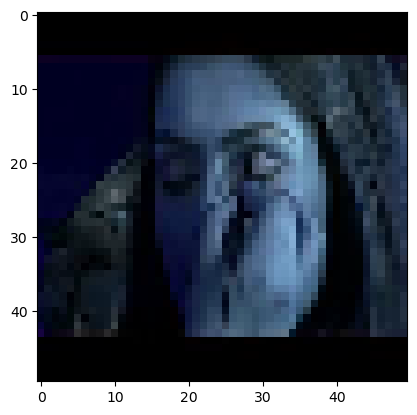

In [17]:
# plt.imshow(X_train[0, 0, :, :, :]) # X_res
plt.imshow(X_res[0, 0, :, :, :])

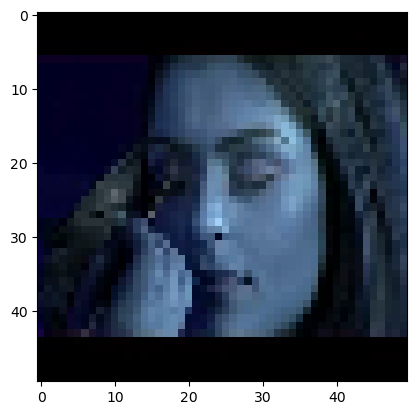

In [18]:
# X_train
# ->
plt.imshow(X_res[0, -1, :, :, :])

Remark: low image resolution + short sequence can hinder the performance.

Define a model of type CNN-LSTM using the layer **ConvLSTM2D** in Keras.

The parameter <code>data_format = "chanels_last"</code> specifies that the "channels" describe color in the format RGB and are stored in the last dimension .

In [19]:
# (k)
model = Sequential()

model.add(ConvLSTM2D(
    filters=64,
    kernel_size=(3,3),
    input_shape=X_train.shape[1:], # (timesteps, width, height, channels)
    name='ConvLSTM'))
# {ConvLSTM -> conv}

model.add(Dropout(0.2))

model.add(Conv2D(filters=128,
                kernel_size=(3,3),
                data_format="channels_last",
                padding="valid",
                name="conv"))

model.add(GlobalAveragePooling2D())
# conv -> dense

model.add(Dense(256, activation="relu", name='dense_256'))

model.add(Dropout(0.3, seed=42))

model.add(Dense(2, activation='softmax', name='output'))

/home/alex/anaconda3/envs/video_classif1/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
"""
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 ConvLSTM (ConvLSTM2D)       (None, 48, 48, 64)        154624    
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv (Conv2D)               (None, 46, 46, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
=================================================================
Total params: 262018 (1023.51 KB)
Trainable params: 262018 (1023.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
"""

# (l)
print(model.summary())
# 262000 parameters, all trainable

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ConvLSTM (ConvLSTM2D)           │ (None, 48, 48, 64)     │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv2D)                   │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,018 (1023.51 KB)

 Trainable params: 262,018 (1023.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
# (m)
optim_SGD = SGD(learning_rate=0.001)
# https://keras.io/api/optimizers/sgd/

In [22]:
# (n)
model.compile(optimizer=optim_SGD,  # Keras optimiser of kind _Stochastic Gradient Descent_
                loss="categorical_crossentropy",  # cost function adapted for  multiclass classification
                metrics=['acc'])  # metrics of model _accuracy_

In [23]:
# Train the model over 10 epochs with batch size 8, without validation set.
batch_size = 8
epochs = 10
model_history = model.fit(
            x=X_res,
            y=y_res_onehot,
            batch_size=batch_size,
            epochs = epochs,
            verbose=True)

# Previous version (2fev) : 9min30 on my machine.
# This version: 9min . 


Epoch 1/10


2026-02-10 15:06:03.838479: E tensorflow/core/util/util.cc:131] oneDNN supports DT_UINT8 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - acc: 0.5000 - loss: 0.6972
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - acc: 0.4756 - loss: 0.7055
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - acc: 0.5793 - loss: 0.6856
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.5000 - loss: 0.6943
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5122 - loss: 0.6946
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.5549 - loss: 0.6841
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5488 - loss: 0.6802
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - acc: 0.5305 - loss: 0.6839
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.5671 - loss: 0.6825
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - acc: 0.6037 - loss: 0.6805


* (p) Predict the probabilities pour X_test

* (q) keep only the  argmax using the corresponding function from numpy 

* (r) Print the classification report

In [24]:
# (p)
y_proba = model.predict(X_test)
print(type(y_proba))  # ndarray
print(y_proba.shape)  # (78, 2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
<class 'numpy.ndarray'>
(78, 2)


In [ ]:
# (q)
def pred_mat2class(pred_matrix):
    return pred_matrix.argmax(axis=1)


y_pred = pred_mat2class(y_proba)
y_test_cl = pred_mat2class(y_test)

print(y_pred[:10])  # [0 0 1 0 0 0 0 1 1 0] for this model. Remark: [0 0 1 1 0 0 1 0 0 0] leads to a more accurate model
print(y_test_cl[:10])  # [0 0 0 0 0 0 1 1 0 1]

[0 0 1 0 0 0 0 1 1 0]
[0 0 0 0 0 0 1 1 0 1]


In [26]:
print(y_test.shape)  # (78, 2)

(78, 2)


In [27]:
"""
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        46
           1       0.54      0.41      0.46        32

    accuracy                           0.62        78
   macro avg       0.59      0.58      0.58        78
weighted avg       0.60      0.62      0.60        78


"""

# (r)
print(classification_report(y_test_cl, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.76      0.70        46
           1       0.54      0.41      0.46        32

    accuracy                           0.62        78
   macro avg       0.59      0.58      0.58        78
weighted avg       0.60      0.62      0.60        78



In [28]:
# Save the model
# model.save("models/model.keras")

The minority class is harder to predict, but precision/recall are quite balanced, which means that the imbalance is no longer to blame.

The model can be improved using these ideas:
<ul>
    <li>increase the length of training (for this model is still learning at the epoch number 10).
    <li>preprocess the videos using Optical Flow.
    <li>check for overfitting, and whether the number of frames can be reduced, for 15 frames in 3 sec may be excessive.</li>
</ul>

# Take-away.

* The layer **ConvLSTM** of _Keras_ allows processing videos by combining  convolution with an architecture of more usual LSTM.

* The data in a **ConvLSTM** usually is 5D, the dimensions being <code>(N_samples, N_timesteps, N_width, N_height, N_channel)</code> .

* RAM can be optimised during the operation of cutting videos and image loading, using a custom generator. An example is presented [here](https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7).
